In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1

Model:

Let's consider the following problem about gambling: 

We have a game where, each turn, I have the probability to win a 1€ equal to $p_1=0.3$, to win 2€ equal to $p_2=0.1$ ad to lose 1€ equal to $p_{-1}=0.6$. The game ends if the player's sum reach N€ or 0€ with $N=5$. For the sake of this simulation, having capped the sum to 5€, we will consider the $p_1$ for the transition $4\rightarrow 5$ equal to $0.4$ to grant the well definition of the problem.  

We have to model this scenario defining the transition matrix, implement a function to check if the matrix is well-defined and test the defined matrix. At last calculate, given a initial probability distribution, the probability for each state after 8 steps.

![Alt text](es1.PNG "graph")

In [2]:
#MATRIX DEFINITION:

game_matrix = np.matrix([
    [1.0,0,0,0,0,0],
    [0.6,0,0.3,0.1,0,0],
    [0,0.6,0,0.3,0.1,0],
    [0,0,0.6,0,0.3,0.1],
    [0,0,0,0.6,0,0.4],
    [0,0,0,0,0,1.0]
])

In [3]:
#A well defined matrix is squared, with all probability values and sum up to one.
#We will check the sum up to an epsilon equal to 1e-7 due to machine error

def defined_check(M: np.matrix)->None:
    '''
    It will check if the given transition matrix is well defined
    '''
    #Check if the matrix is squared
    if(np.shape(M)[0]!=np.shape(M)[1]):
       raise RuntimeError("Number of rows is different from the number of columns")

    for i in range(len(M)):
        s = 0
        
        for j in range(len(M)):
            #Check if the values are actualy probabilities
            if(M[i,j]>1 or M[i,j]<0):
                raise RuntimeError("An element of the transition matrix is not a probability: "+str(i)+","+str(j))
            
            s = s + M[i,j]

        #Check if the rows sum up to 1
        if(s-1>0.00000001):
            raise RuntimeError("The matrix is not well defined. Goes over 1 in the row "+str(i)+" with a value "+str(s))
         

In [4]:
defined_check(game_matrix)

In [5]:
def DTMC_pred_forward(p0: np.array,mat: np.matrix, time: int)->np.array: #POSSIBILE ASSIGNMENT FARE LA MATRICE OPPOSTA
    '''
    Calculate, given an initial probability array p0 of the states
    what will be the probability array after "time" interactions
    '''
    #if time=0 no projections have to be made
    if(time==0):
        return p0

    #if time is negative it as no sense 
    if(time<0):
        raise RuntimeError("Negative time for forward prediction")

    #Default:
    matpow = mat
    for i in range(1,time):
        matpow = np.matmul(matpow,mat)

    return np.array(np.dot(p0,matpow))[0]

In [6]:
prob_init = np.array([0,0,1,0,0,0])
prob_out = DTMC_pred_forward(prob_init,game_matrix,8)

print(prob_out)

[0.626328   0.02659392 0.0431568  0.03281472 0.01872072 0.25238584]


## Exercise 2

Let's implement a basic class for the DTMC to use and modify then in the following exercises. We will simply copy and paste the function defined above and give them a general form.

In [7]:
class DTMC(object):

    #CONSTRUCTOR
    def __init__(self,P: np.matrix)->None:
        self.transition_mat=P
        self._msize=len(P)
        self.defined_check(self,self.transition_mat)
        return

    #CHECK METHOD
    @staticmethod
    def defined_check(self, M: np.matrix)->None:
        '''
        It will check if the given transition matrix is well defined
        '''
        #Check if the matrix is squared
        if(np.shape(M)[0]!=np.shape(M)[1]):
           raise RuntimeError("Number of rows is different from the number of columns")
    
        for i in range(self._msize):
            s = 0
            
            for j in range(self._msize):
                #Check if the values are actualy probabilities
                if(M[i,j]>1 or M[i,j]<0):
                    raise RuntimeError("An element of the transition matrix is not a probability: "+str(i)+","+str(j))
                
                s = s + M[i,j]
    
            #Check if the rows sum up to 1
            if(s-1>0.00000001):
                raise RuntimeError("The matrix is not well defined. Goes over 1 in the row "+str(i)+" with a value "+str(s))

        return

    #PREDICTION METHOD
    def compute_pred_forward(self, p0: np.array, time: int)->np.array:
        '''
        Calculate, given an initial probability array p0 of the states
        what will be the probability array after "time" interactions
        '''
        #if time=0 no projections have to be made
        if(time==0):
            return p0
    
        #if time is negative it as no sense 
        if(time<0):
            raise RuntimeError("Negative time for forward prediction")
    
        #Default:
        matpow = self.transition_mat
        for i in range(1,time):
            matpow = np.matmul(matpow,self.transition_mat)
    
        return np.array(np.dot(p0,matpow))[0]

In [8]:
chain = DTMC(game_matrix)
prob_init = np.array([0,0,1,0,0,0])
prob_out = chain.compute_pred_forward(prob_init,8)

print(prob_out)

[0.626328   0.02659392 0.0431568  0.03281472 0.01872072 0.25238584]


## Exercise 3

Considering the model in the Exercise 1. We will now try to implement a version where there is no limit in how much money the Player can hold. In other words the space of the states is now coincident with $\mathbb{N}$ and the only absorbing state will be 0€. 

In [9]:
#NOW, TO DEFINE THE MATRIX WITHOUT DOING SIMULATIONS, WE HAVE TO USE AN ADAPTIVE METHOD. THERE ARE TWO GENERAL WAY:
#- THE FULL MATRIX AS DONE BEFORE
#- USING A SPARSE MATRIX SYSTEM: THIS IS MORE CHEAP IN TERM OF SPACE BUT REQUIRE A BIT MORE OF IMPLEMENTATION ESPECIALLY TO DO THE MULTIPLICATIONS THEN.
#  IT'S EVENTUALLY POSSIBLE TO USE THE SPARSE MATRICES OF SCIPY

# WE WILL TRY THE FIRST WAY

In [10]:
def compute_game_matrix(p0: np.array, N: int)->np.matrix:
    '''
    This function will compute the matrix for the game with adapting
    to the prob_init number of values and iterations
    '''

    #The size of the matrix will be the size of the p0 + N*2 + 1 in our problem
    #The last one will not be reachable but is needed to close the problem
    
    m_size = len(p0)+N*2+1
    M = np.matrix(np.zeros((m_size,m_size),dtype=float)) #Matrix definition

    #Setup the 0 state
    M[0,0] = 1.0

    #Setup the other states until the -2
    for i in range(1,m_size-2):
        M[i,i-1] = 0.6
        M[i,i+1] = 0.3
        M[i,i+2] = 0.1

    #Setup the -2
    M[-2,-3] = 0.6
    M[-2,-1] = 0.4

    #Setup the last
    M[-1,-1] = 1.0
        
    return M
    

In [11]:
def vector_expansion(p0: np.array, N: int)->np.array:
    '''
    This function will expand the initial probability array
    to the correct size for the number of the iterations
    '''

    v_size = N*2+1

    prob_init = np.concatenate([p0,np.zeros(v_size,dtype=float)],axis=0)
    
    return prob_init

In [13]:
prob_init = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
n_iterations = 20

game_matrix_nolimit = compute_game_matrix(prob_init,n_iterations)
prob_init = vector_expansion(prob_init,n_iterations)

In [14]:
chain = DTMC(game_matrix_nolimit)
prob_out = chain.compute_pred_forward(prob_init,8)

print(prob_out)

[3.50922112e-01 3.45954240e-02 5.39110080e-02 7.06371840e-02
 7.52950080e-02 8.04148560e-02 7.30386720e-02 6.76209060e-02
 5.57795700e-02 4.45859910e-02 3.35537910e-02 2.34075150e-02
 1.55973870e-02 9.61758900e-03 5.52779700e-03 2.96975100e-03
 1.45863900e-03 6.57280000e-04 2.69695000e-04 9.79750000e-05
 3.11950000e-05 8.51500000e-06 1.83700000e-06 2.77000000e-07
 2.50000000e-08 1.00000000e-09 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


<BarContainer object of 51 artists>

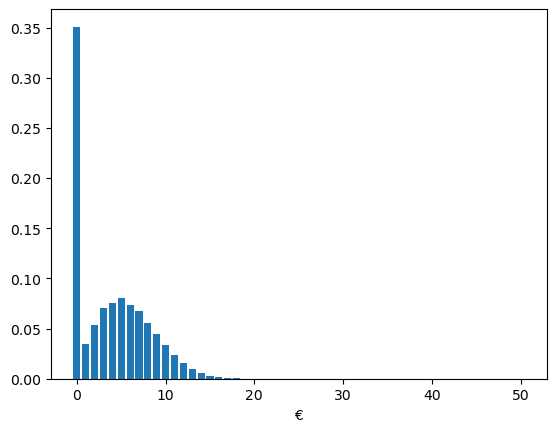

In [15]:
x = np.linspace(0,len(prob_out)-1,len(prob_out))

plt.xlabel("€")

plt.bar(x,prob_out)

## Exercise 4

As seen in the exercise above for infinite chains the usage of a matrix can be quite difficult even in a sparse implementation. However another problem working with matrix can appear when working with event spaces with too many elements that will produce enormous matrices or nonhomogenous probability situations. This problem can appear when using a too great number of iterations.

In this case a simulative approach can be useful. We will try to write in this way the problem in the cell below and do some simuation given a starting probability array. This simulation method is based on an experimental mind set in which i send some entities inside the system and see how it reacts to them.

**PROBLEM**: Given a space of 1000 possible states. Suppose we are in a state $i$ we will have the following possible transitions:

- $i\rightarrow i\pm 1$ with $p=0.25$
- $i\rightarrow i\pm 2$ with $p=0.125$
- $i\rightarrow i\pm 3$ with $p=0.0625$
- $i\rightarrow i\pm 4$ with $p=0.03125$
- $i\rightarrow i\pm 5$ with $p=0.03125$

Suppose cyclic conditions at the border of the space. So if $i=4$ the transition to $-5$ will point to $999+4-5=998$. In a similar way if $i=998$ the transition $+5$ will have to point at $i=4$.

In [16]:
import random
import time
random.seed(time.time())

In [17]:
#LET'S IMPLEMENT IS USING THE ABOVE CLASS OF DTMC. WE HAVE TO REMOVE THE MATRIX METHODS TO DO THE SIMULATIVE APPROACH
class DTMC_1000(object):

    #CONSTRUCTOR
    def __init__(self)->None:
        self.n_states=1000
        return

    #COMPUTE CUMULATIVE PROBABILITY ARRAY
    def __cumulativeTransformer(self,p0:np.array)->np.array:
        '''
        Given a probability array this function will compute
        the cumulative of such distribution.
        '''
        p = np.zeros(len(p0),dtype=float)
        p[0] = p0[0]

        for i in range(1,len(p)):
            p[i] = p0[i] + p[i-1]
        
        return p

    #INITIAL STATE COMPUTING
    def __obtainState(self,p0:np.array)->int:
        '''
        Given a probability distribution of the state this function will
        produce a weighted random state.
        '''
        p = self.__cumulativeTransformer(p0)

        r = random.random()
        s = 0
        
        for i in range(len(p0)):
            if((r<p[i]) and ((p[i]-p[i-1])>0.0000001)):
                s = i
                break
        
        return s

    def __createProbTransitions(self,S: int)->np.array:
        '''
        Given the starting state. The method will produce the probability
        distribution of the transitions
        '''
        p = np.zeros(self.n_states,dtype=float)

        steps = [-5,-4,-3,-2,-1,1,2,3,4,5]
        values = [0.03125,0.03125,0.0625,0.125,0.25,0.25,0.125,0.0625,0.03125,0.03125]

        for i in range(len(steps)):
            if((S+steps[i])<1000):
                p[S+steps[i]]=values[i]
            else:
                p[S+steps[i]-1000]=values[i]

        return p
        

    #SIMULATION METHOD
    def __simulateTraj(self,p0:np.array,time: int)->int:
        '''
        This function will simulate a trajectory of the DTMC_1000
        '''
        state = self.__obtainState(p0)

        for i in range(time):
            p = self.__createProbTransitions(state)
            state = self.__obtainState(p)

        return state
        
    
    #MAIN PREDICTION METHOD
    def compute_pred_forward(self, p0: np.array, time: int, N: int)->np.array:
        '''
        Calculate, given an initial probability array p0 of the states
        what will be the probability array after "time" interactions.
        N simulation will be performed.
        '''
        #if time=0 no projections have to be made
        if(time==0):
            return p0
    
        #if time is negative it as no sense 
        if(time<0):
            raise RuntimeError("Negative time for forward prediction")

        #Check N
        if(N<0):
            raise RuntimeError("Negative number of simulations")
    
        #Create the bins vector
        bins = np.zeros(self.n_states,dtype=float)
        
        for i in range(N):
            s = self.__simulateTraj(p0,time)
            bins[s] += 1.0

        #Normalization
        bins = bins/N
        
        return bins

In [18]:
chain = DTMC_1000()

p_init = np.zeros(1000,dtype=float)
p_init[500] = 1.0

p_out = chain.compute_pred_forward(p_init,30,1000)

In [19]:
print(p_out)

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0

<BarContainer object of 1000 artists>

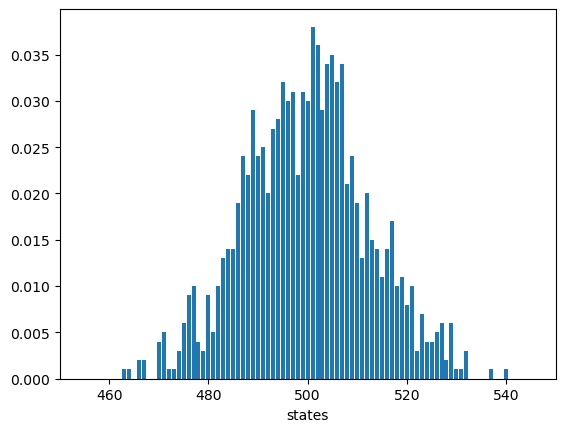

In [20]:
x = np.linspace(0,len(p_out)-1,len(p_out))

plt.xlabel("states")
plt.xlim(450,550)

plt.bar(x,p_out)

## Exercise 5

In this exercise we will start to work with some unhomogenous matrix. This type of problems we will allow us to present another important type of simulations.

Generally speaking there are two huge macro approach to the simulations in systems: the SD and the ABM. For the SD the book Thinking in Systems can be useful. However certain problem can be described using both the two approach while other can be written using only one of the two approches. Some problems are even an hybrid between two of them. If you want, at the end of this course I can do a small lecture about these two approaches. 

However, the simulations of all these kind of systems can be done again with one of the two methods and sometimes the implentation and simulation method will not coincide. 

We want to take in consideration the classical SIR problem.

**SIR**: the SIR model is the most basic mathematical model to describe the behaviour of an epidemy. It works pretty well with malaria and it's used as base model to most complex epidemic model. According to the SIR, during an epidemy, all thhe population can be categorized in three classes: Susceptible, Infect, Removed. At each time instant we have that a person can pass from a class to another with a certain probability. The problem is that this probability is not fixed in time but depends on how many subjects there are for each category (es. the infection of a subsceptible is proportionaly frequent to the number of infects).
We have the following defined transition

- S -> I
- I -> R

This POV is based on a ABM approach but this problem can be also treated in SD considering not the single person but the number of subjects in each category.

Now we want to model a DTMC that will tell us given the starting probability for a person to be in each one of the categories the probability vector after a certain time of iterations $n$. Obviously the scenario we will change according to distribution of the population between the three categories at the beginning of the simulation. 

The general idea to solve this problem is the subsequent. We will compute given a probability distribution using the matrix method. To compute the matrix we will performed a simulation with 1000 Agents that form the population that will evolve. This method allows us to consider a different initial probability distribution for the population and for our simulation. 
Technically doing this is as having a single person with an initial probability of being in one of the three states and look how it evolves. Obviously having different behaviours for the population we will need also to repeat this experiment multiple time and consider the mean probability distribution. 

This is not the only simulative method. There are different possibilities modelling different aspects. It's also theoretically possible to consider the population in a SD approach and evolve it. Obviously in this situation the equations will be different and computation of the matrix will be based on different mathematical operations. It's also possible to consider the population distribution and evolve it separately using the matrix and produce the newest with the new distribution.